In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array,array_to_img,ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout,Conv2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [106]:
base_path = './drive/MyDrive/Colab Notebooks/malaria_dataset/'

In [107]:
folders = glob(base_path+'Train/Parasite/*')
folders[0]

'./drive/MyDrive/Colab Notebooks/malaria_dataset/Train/Parasite/C133P94ThinF_IMG_20151004_155721_cell_124.png'

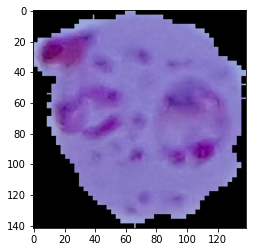

In [108]:
img_para_path = folders[0]
img_arr = cv2.imread(img_para_path)
plt.imshow(img_arr)

In [109]:
datagen = ImageDataGenerator(rescale= 1./255,preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(base_path+'Train/',
                                        class_mode='binary',
                                       target_size=(224,224),
                                       batch_size=1)
test_gen = datagen.flow_from_directory(base_path+'Test/',
                                       class_mode='binary',
                                       target_size=(224,224),
                                       batch_size=1)

Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [110]:
img_shape = [224,224]

In [111]:
# base_model = ResNet152V2(input_shape=img_shape+[3],weights='imagenet',include_top=False)

In [112]:
# for layer in base_model.layers:
#   layer.trainable=False

In [113]:
model = Sequential([
                    Conv2D(128,kernel_size=(2,2),padding='same',activation='relu',input_shape=(224,224,3)),
                    Conv2D(64,kernel_size=(2,2),padding='same',activation='relu'),
                    Conv2D(32,kernel_size=(2,2),padding='same',activation='relu'),
                    GlobalAveragePooling2D(),
                    Dense(64,activation='relu'),
                    Dropout(0.25),
                    Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 128)     1664      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 224, 224, 64)      32832     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 224, 224, 32)      8224      
_________________________________________________________________
global_average_pooling2d_9 ( (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [114]:
earlyStop = EarlyStopping(monitor='val_loss',patience=6)
reducelr = ReduceLROnPlateau(monitor='val_loss',
                             min_lr=0.0001,
                             patience=2)

callbacks = [earlyStop,reducelr]

In [115]:
train_step_size = train_gen.n//train_gen.batch_size
test_step_size = test_gen.n//test_gen.batch_size

training = model.fit(train_gen,
                    steps_per_epoch=train_step_size,
                    epochs=30,
                    validation_data=test_gen,
                    validation_steps=test_step_size,
                    callbacks=callbacks
                    )

Epoch 1/30
416/416 [==============================] - 11s 24ms/step - loss: 0.6785 - accuracy: 0.5838 - val_loss: 0.8008 - val_accuracy: 0.5746
Epoch 2/30
416/416 [==============================] - 10s 24ms/step - loss: 0.5586 - accuracy: 0.7402 - val_loss: 1.0985 - val_accuracy: 0.4328
Epoch 3/30
416/416 [==============================] - 10s 24ms/step - loss: 0.5220 - accuracy: 0.7522 - val_loss: 0.5264 - val_accuracy: 0.7388
Epoch 4/30
416/416 [==============================] - 10s 24ms/step - loss: 0.2872 - accuracy: 0.8927 - val_loss: 0.2973 - val_accuracy: 0.8806
Epoch 5/30
416/416 [==============================] - 10s 24ms/step - loss: 0.1464 - accuracy: 0.9550 - val_loss: 0.2752 - val_accuracy: 0.8955
Epoch 6/30
416/416 [==============================] - 10s 24ms/step - loss: 0.1446 - accuracy: 0.9402 - val_loss: 0.1312 - val_accuracy: 0.9328
Epoch 7/30
416/416 [==============================] - 10s 24ms/step - loss: 0.1398 - accuracy: 0.9704 - val_loss: 0.1902 - val_accuracy:

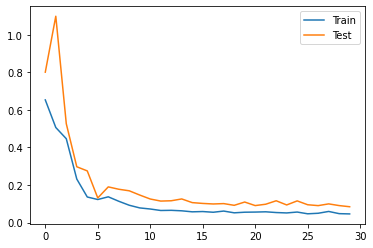

In [116]:
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'],label='Test')
plt.legend()
plt.show()

In [117]:
folder_p = glob(base_path+'Test/Parasite/*')
folder_np = glob(base_path+'Test/Uninfected/*')

(1, 224, 224, 3)

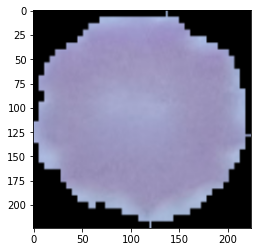

In [118]:
img_par = cv2.imread(folder_np[28])
img_par = cv2.resize(img_par,(224,224))
plt.imshow(img_par)
img_par = img_par.reshape(1,224,224,3)
img_par.shape

In [119]:
res = model.predict(img_par)
res

array([[1.]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


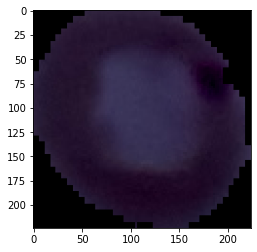

In [120]:
test_gen.reset()
x1 = test_gen.next()

print(x1[1])
plt.imshow(x1[0][0])

In [121]:
rr = model.predict(x1[0][0].reshape(1,224,224,3))
np.round(rr.reshape(-1))

array([0.], dtype=float32)

In [122]:
model.evaluate(test_gen)

134/134 [==============================] - 1s 8ms/step - loss: 0.0845 - accuracy: 0.9552


[0.08448748290538788, 0.9552238583564758]

In [124]:
model.save('./drive/MyDrive/Colab Notebooks/malaria_dataset/malaria_detection_model.h5')